# 05. Time Series Regression and Classification
- Time Series 데이터의 특징을 반영하여 Regression으로 Target 변수인 **5일 후(t+5시점) 지수종가**를 예측하고 t시점의 지수종가와 비교하여 Classification 문제로 반환한다.

## 2. GRU Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from encodings import euc_kr
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import to_categorical

np.random.seed(777)

Using TensorFlow backend.


In [2]:
final = pd.read_csv('./final_merge.csv',encoding = 'euc-kr')
kospi = pd.read_csv('./data/kospi_국면분석.csv',encoding = 'euc-kr')
final_eco = pd.read_csv('./f_with_e2.csv',encoding = 'euc-kr')

In [3]:
#지수만 있는 버전
kospi_add = kospi[['날짜','지수시가','지수저가','지수고가']]

In [4]:
Final = final_eco.merge(kospi_add,how = 'left',on = '날짜')
Final.head()

,날짜,지수종가,거래대금,상장주식수,시가총액,외국인보유주식수,외국인보유시가총액,신용거래종목수,신용자료일자,회사수,...,제조업내수출하지수(원지수),제조업생산-제조업,제조업생산출하-제조업,코스피지수(1980.1.4=100)(선행),필라델피아연준지수[미국],후행종합지수(2015=100),Y,지수시가,지수저가,지수고가
0,2001-01-02,520.95,1223328,19638887,191252891,2723222,58238292,746.0,20010102.0,704,...,64.962,48.36,51.915,551.8,-36.2,54.7,상승,503.31,500.97,521.34
1,2001-01-03,521.43,1583403,19633559,191363161,2727918,58249739,746.0,20010102.0,704,...,64.962,48.36,51.915,551.8,-36.2,54.7,상승,512.74,510.70,524.58
2,2001-01-04,558.02,2984761,19634734,204074166,2735566,62823637,746.0,20010102.0,704,...,64.962,48.36,51.915,551.8,-36.2,54.7,상승,551.53,550.91,567.16
3,2001-01-05,580.85,3569582,19637038,212089180,2747453,65820417,746.0,20010103.0,704,...,64.962,48.36,51.915,551.8,-36.2,54.7,상승,559.54,555.40,581.41
4,2001-01-08,586.65,2948092,19630735,214231273,2751599,66348238,746.0,20010104.0,704,...,64.962,48.36,51.915,551.8,-36.2,54.7,상승,573.72,572.48,587.91


In [5]:
final_eco = final.drop(['Unnamed: 0','Y'],axis = 1)
final_eco['5일후 지수종가'] = final_eco['지수종가'].shift(-5)
final_eco.head()

,날짜,지수종가,거래대금,상장주식수,시가총액,외국인보유주식수,외국인보유시가총액,신용거래종목수,신용자료일자,회사수,...,금속,oil,미국n년,국고채권(n년),USD,EUR,CNY,JPY,GBP,5일후 지수종가
0,2001-01-02,520.95,1223328,19638887,191252891,2723222,58238292,746.0,20010102.0,704,...,7202.5,25.8,8.5,11.9,1259.7,1185.38,152.19,1099.07,1885.02,589.92
1,2001-01-03,521.43,1583403,19633559,191363161,2727918,58249739,746.0,20010102.0,704,...,6641.3,26.5,8.6,11.8,1267.8,1205.49,153.15,1108.07,1903.35,560.81
2,2001-01-04,558.02,2984761,19634734,204074166,2735566,62823637,746.0,20010102.0,704,...,6843.0,26.8,8.3,11.4,1285.4,1193.24,155.29,1128.53,1914.15,561.79
3,2001-01-05,580.85,3569582,19637038,212089180,2747453,65820417,746.0,20010103.0,704,...,6878.7,26.6,8.0,11.0,1249.3,1190.90,150.92,1078.01,1876.82,587.87
4,2001-01-08,586.65,2948092,19630735,214231273,2751599,66348238,746.0,20010104.0,704,...,7012.1,25.8,8.0,10.9,1267.8,1215.06,153.16,1088.71,1906.33,599.00


In [6]:
# '날짜' 변수를 datetime 타입으로 변환하고 index로 사용하기
# 잠시만 안녕
#data1['날짜'] = pd.to_datetime(data1['날짜'],format = '%Y/%m/%d')
#col_name = data1.drop('날짜',axis = 1).columns
#data = data1.set_index('날짜').dropna()
#values = data.values #dataframe형태를 array로 변환한 ver.

final_eco['날짜'] = pd.to_datetime(final_eco['날짜'],format = '%Y/%m/%d')
col_name = final_eco.drop('날짜',axis = 1).columns
data = final_eco.set_index('날짜').dropna()
values = data.values #dataframe형태를 array로 변환한 ver.

In [7]:
# scaling - minmax
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(values)
data_scaled = pd.DataFrame(data_scaled,columns = col_name)
print(data_scaled.shape) ##(4276,95)
values = data_scaled.values
print(values.shape) ##(4276,95)

(4444, 39)
(4444, 39)


(3962, 1, 38) (3962, 1)
(482, 1, 38) (482, 1)


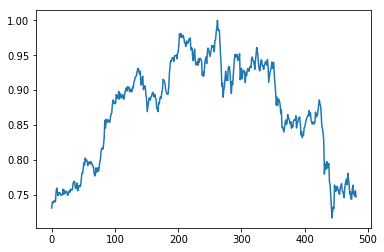

In [8]:
# train / test 나누기
#data[data['날짜']=='2017-01-02'] #3962
#values = reframed.values #(4443, 78) 
#print(values.shape)
train_frame = values[:3962,:] ##불포함 3802
test_frame = values[3962:,:]

# array로 변환
#train = train_frame.values
#test = test_frame.values

# 데이터셋 생성
#look_back = 100

#trainX, trainY = build_dataset(train_frame, seq_length)
#testX, testY = build_dataset(train_frame, seq_length)

train_X, train_y = train_frame[:, 1:], train_frame[:, 0] # (3802,1,94) (3802,1)
test_X, test_y = test_frame[:, 1:], test_frame[:, 0] # (474,1,94) (474,1)

# 3차원으로 변환(LSTM input 형식에 맞추기)
train_X = train_X.reshape(train_X.shape[0],1,train_X.shape[1])
train_y = train_y.reshape(train_y.shape[0],1)
test_X = test_X.reshape(test_X.shape[0],1,test_X.shape[1])
test_y = test_y.reshape(test_y.shape[0],1)
print(train_X.shape,train_y.shape) # (3802,1,94) (3802,1)
print(test_X.shape,test_y.shape) # (474,1,94) (474,1)
plt.plot(test_y)

## GRU
### (1) batch_size = 140 / iterations = 5000 / hidden layers = 20 / activation = leaky-ReLU

In [9]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 140 ; print(batch_size) ##14
iterations = 5000

3962
38
1
140


In [11]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 20, activation=tf.nn.leaky_relu)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Tensor("rnn/transpose_1:0", shape=(?, ?, 20), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 20), dtype=float32)


[step: 0] loss: 1221.0924072265625
[step: 100] loss: 2.0132100582122803
[step: 200] loss: 1.3050799369812012
[step: 300] loss: 1.0012298822402954
[step: 400] loss: 0.7823354005813599
[step: 500] loss: 0.6210416555404663
[step: 600] loss: 0.5043148398399353
[step: 700] loss: 0.4208769202232361
[step: 800] loss: 0.36028003692626953
[step: 900] loss: 0.31286734342575073
[step: 1000] loss: 0.27656322717666626
[step: 1100] loss: 0.2491617500782013
[step: 1200] loss: 0.22685471177101135
[step: 1300] loss: 0.2089555561542511
[step: 1400] loss: 0.19331838190555573
[step: 1500] loss: 0.17915917932987213
[step: 1600] loss: 0.16592587530612946
[step: 1700] loss: 0.15348036587238312
[step: 1800] loss: 0.14157746732234955
[step: 1900] loss: 0.13010762631893158
[step: 2000] loss: 0.1191641166806221
[step: 2100] loss: 0.10917655378580093
[step: 2200] loss: 0.10752104967832565
[step: 2300] loss: 0.0908852145075798
[step: 2400] loss: 0.08223827928304672
[step: 2500] loss: 0.11755380779504776
[step: 260

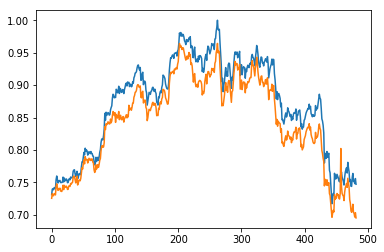

In [12]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [42]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_1 = test_predict
pred_GRU_1.shape

(482, 1)

In [43]:
test_kospi = test_frame[:, 0].reshape(test_frame.shape[0],1)
test_kospi.shape

(482, 1)

In [81]:
diff = test_predict - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.42946058091286304  
confusion matrix:
 [[184  30]
 [245  23]]
f1: 0.14330218068535824


### (2) batch_size = 200 / iterations = 4000 / hidden layers = 30 / activation = leaky-ReLU

In [29]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 200 ; print(batch_size) ##14
iterations = 4000

3962
38
1
200


In [30]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 30, activation=tf.nn.leaky_relu)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Tensor("rnn/transpose_1:0", shape=(?, ?, 30), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 30), dtype=float32)


[step: 0] loss: 1469.7193603515625
[step: 100] loss: 3.449556589126587
[step: 200] loss: 1.8566192388534546
[step: 300] loss: 1.3040554523468018
[step: 400] loss: 0.9504029154777527
[step: 500] loss: 0.7280986905097961
[step: 600] loss: 0.581376850605011
[step: 700] loss: 0.48645520210266113
[step: 800] loss: 0.4207478165626526
[step: 900] loss: 0.37135955691337585
[step: 1000] loss: 0.33206167817115784
[step: 1100] loss: 0.2990863621234894
[step: 1200] loss: 0.26986661553382874
[step: 1300] loss: 0.24340996146202087
[step: 1400] loss: 0.21886463463306427
[step: 1500] loss: 0.1961776465177536
[step: 1600] loss: 0.1753959357738495
[step: 1700] loss: 0.1582179218530655
[step: 1800] loss: 0.14350064098834991
[step: 1900] loss: 0.13420186936855316
[step: 2000] loss: 0.15299507975578308
[step: 2100] loss: 0.10937722027301788
[step: 2200] loss: 0.10037200152873993
[step: 2300] loss: 0.09260725229978561
[step: 2400] loss: 0.08483921736478806
[step: 2500] loss: 0.14430534839630127
[step: 2600]

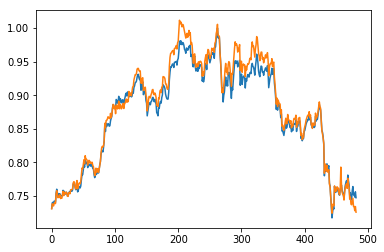

In [31]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [32]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_2 = test_predict

In [80]:
diff = pred_GRU_2 - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.5601659751037344  
confusion matrix:
 [[ 47 167]
 [ 45 223]]
f1: 0.6778115501519757


### (3) batch_size = 200 / iterations = 4000 / hidden layers = 40 / activation = leaky-ReLU

In [47]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 200 ; print(batch_size) ##14
iterations = 4000

3962
38
1
200


In [48]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 40, activation=tf.nn.leaky_relu)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Tensor("rnn/transpose_1:0", shape=(?, ?, 40), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 40), dtype=float32)


[step: 0] loss: 1173.86962890625
[step: 100] loss: 1.9785608053207397
[step: 200] loss: 1.2087587118148804
[step: 300] loss: 0.9332165718078613
[step: 400] loss: 0.7352278232574463
[step: 500] loss: 0.5904406905174255
[step: 600] loss: 0.48235273361206055
[step: 700] loss: 0.40235623717308044
[step: 800] loss: 0.34292230010032654
[step: 900] loss: 0.2992083430290222
[step: 1000] loss: 0.26522013545036316
[step: 1100] loss: 0.23665271699428558
[step: 1200] loss: 0.211088627576828
[step: 1300] loss: 0.18737152218818665
[step: 1400] loss: 0.16578829288482666
[step: 1500] loss: 0.1463506817817688
[step: 1600] loss: 0.1292017549276352
[step: 1700] loss: 0.11395777761936188
[step: 1800] loss: 0.16473589837551117
[step: 1900] loss: 0.13856707513332367
[step: 2000] loss: 0.08388570696115494
[step: 2100] loss: 0.07926781475543976
[step: 2200] loss: 0.07219840586185455
[step: 2300] loss: 0.10560515522956848
[step: 2400] loss: 0.10443221777677536
[step: 2500] loss: 0.08903588354587555
[step: 2600

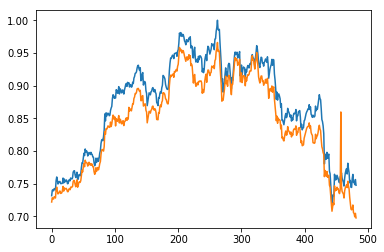

In [49]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [50]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_3 = test_predict

In [79]:
diff = pred_GRU_3 - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.44190871369294604  
confusion matrix:
 [[213   1]
 [268   0]]
f1: 0.0


### (4) batch_size = 200 / iterations = 4000 / hidden layers = 30 / activation = tanh

In [52]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 200 ; print(batch_size) ##14
iterations = 4000

3962
38
1
200


In [53]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 30, activation=tf.nn.tanh)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Tensor("rnn/transpose_1:0", shape=(?, ?, 30), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 30), dtype=float32)


[step: 0] loss: 1936.87060546875
[step: 100] loss: 3.2357163429260254
[step: 200] loss: 1.7773425579071045
[step: 300] loss: 1.4220643043518066
[step: 400] loss: 1.1936932802200317
[step: 500] loss: 1.0089415311813354
[step: 600] loss: 0.8523607850074768
[step: 700] loss: 0.7198978662490845
[step: 800] loss: 0.6096904873847961
[step: 900] loss: 0.5196059942245483
[step: 1000] loss: 0.4468868672847748
[step: 1100] loss: 0.3883637487888336
[step: 1200] loss: 0.3408259153366089
[step: 1300] loss: 0.301433265209198
[step: 1400] loss: 0.26804083585739136
[step: 1500] loss: 0.23929187655448914
[step: 1600] loss: 0.21436774730682373
[step: 1700] loss: 0.19258400797843933
[step: 1800] loss: 0.17321251332759857
[step: 1900] loss: 0.15558543801307678
[step: 2000] loss: 0.13924555480480194
[step: 2100] loss: 0.13910318911075592
[step: 2200] loss: 0.12024860829114914
[step: 2300] loss: 0.10727345943450928
[step: 2400] loss: 0.34813517332077026
[step: 2500] loss: 0.09938643872737885
[step: 2600] lo

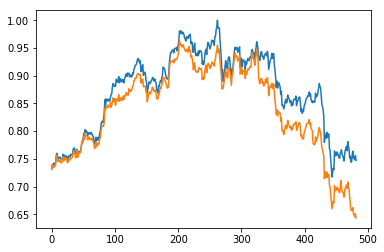

In [54]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [55]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_4 = test_predict

In [78]:
diff = pred_GRU_4 - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.44813278008298757  
confusion matrix:
 [[214   0]
 [266   2]]
f1: 0.014814814814814815


### (5) batch_size = 200 / iterations = 4000 / hidden layers = 30 / activation = ReLU

In [57]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 200 ; print(batch_size) ##14
iterations = 4000

3962
38
1
200


In [58]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 30, activation=tf.nn.relu)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Tensor("rnn/transpose_1:0", shape=(?, ?, 30), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 30), dtype=float32)


[step: 0] loss: 1344.7655029296875
[step: 100] loss: 1.9842581748962402
[step: 200] loss: 1.0995479822158813
[step: 300] loss: 0.7897793650627136
[step: 400] loss: 0.5918663740158081
[step: 500] loss: 0.46933263540267944
[step: 600] loss: 0.39700618386268616
[step: 700] loss: 0.3471528887748718
[step: 800] loss: 0.30690431594848633
[step: 900] loss: 0.27284640073776245
[step: 1000] loss: 0.24299713969230652
[step: 1100] loss: 0.21622030436992645
[step: 1200] loss: 0.19447477161884308
[step: 1300] loss: 0.5340187549591064
[step: 1400] loss: 0.16003826260566711
[step: 1500] loss: 0.5636166930198669
[step: 1600] loss: 0.1341758370399475
[step: 1700] loss: 0.15359832346439362
[step: 1800] loss: 0.11440157890319824
[step: 1900] loss: 0.10408180207014084
[step: 2000] loss: 0.10272233933210373
[step: 2100] loss: 0.0915556401014328
[step: 2200] loss: 0.08412441611289978
[step: 2300] loss: 0.08356545865535736
[step: 2400] loss: 0.0759105458855629
[step: 2500] loss: 0.2070111632347107
[step: 260

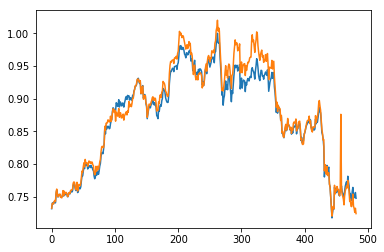

In [59]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [60]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_5 = test_predict

In [77]:
diff = pred_GRU_5 - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.553941908713693  
confusion matrix:
 [[ 61 153]
 [ 62 206]]
f1: 0.657097288676236


### (6) batch_size = 200 / iterations = 3000 / hidden layers = 40 / activation = leaky-ReLU

In [65]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 200 ; print(batch_size) ##14
iterations = 3000

3962
38
1
200


In [66]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 40, activation=tf.nn.leaky_relu)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Tensor("rnn/transpose_1:0", shape=(?, ?, 40), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 40), dtype=float32)


[step: 0] loss: 1111.1636962890625
[step: 100] loss: 2.079123020172119
[step: 200] loss: 1.2098737955093384
[step: 300] loss: 0.8208453059196472
[step: 400] loss: 0.5795459747314453
[step: 500] loss: 0.4215148389339447
[step: 600] loss: 0.3134683668613434
[step: 700] loss: 0.24681517481803894
[step: 800] loss: 0.21169514954090118
[step: 900] loss: 0.17174917459487915
[step: 1000] loss: 0.26077204942703247
[step: 1100] loss: 0.13721589744091034
[step: 1200] loss: 0.109879270195961
[step: 1300] loss: 0.09878002107143402
[step: 1400] loss: 0.09499155730009079
[step: 1500] loss: 0.3097887635231018
[step: 1600] loss: 0.079213947057724
[step: 1700] loss: 0.10589834302663803
[step: 1800] loss: 0.06598139554262161
[step: 1900] loss: 0.06214698404073715
[step: 2000] loss: 0.059186313301324844
[step: 2100] loss: 0.05680152401328087
[step: 2200] loss: 0.052620306611061096
[step: 2300] loss: 0.05324240401387215
[step: 2400] loss: 0.05027102679014206
[step: 2500] loss: 0.34625446796417236
[step: 26

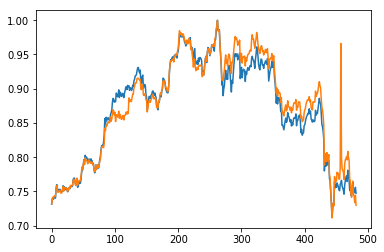

In [67]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [68]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_6 = test_predict

In [76]:
diff = pred_GRU_6 - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.5373443983402489  
confusion matrix:
 [[ 92 122]
 [101 167]]
f1: 0.5996409335727109


### (7) batch_size = 200 / iterations = 4000 / hidden layers = 25 / activation = leaky-ReLU

In [70]:
seq_length = train_X.shape[0] ;print(seq_length) ##3802
data_dim = train_X.shape[2]; print(data_dim) ##94
output_dim = train_y.shape[1]; print(output_dim) ##1
batch_size = 200 ; print(batch_size) ##14
iterations = 4000

3962
38
1
200


In [71]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,[None,None, data_dim])
Y = tf.placeholder(tf.float32,[None,None])
#print(X.shape,Y.shape)


cell = tf.contrib.rnn.GRUCell(num_units = 25, activation=tf.nn.leaky_relu)
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
outputs, _states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32) ; print(outputs,_states)
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn = None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

m = tf.keras.metrics.Accuracy()

# RMSE
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None,1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

#model = Sequential()
#model.add(LSTM(30, input_shape=(train_X.shape[1], 5)))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

Tensor("rnn/transpose_1:0", shape=(?, ?, 25), dtype=float32) Tensor("rnn/while/Exit_3:0", shape=(?, 25), dtype=float32)


[step: 0] loss: 714.3820190429688
[step: 100] loss: 1.8352669477462769
[step: 200] loss: 1.1064980030059814
[step: 300] loss: 0.6376283764839172
[step: 400] loss: 0.36256298422813416
[step: 500] loss: 0.29339781403541565
[step: 600] loss: 0.22897063195705414
[step: 700] loss: 0.1994609534740448
[step: 800] loss: 0.16979898512363434
[step: 900] loss: 0.1471078246831894
[step: 1000] loss: 0.13290348649024963
[step: 1100] loss: 0.11788804084062576
[step: 1200] loss: 0.11075536161661148
[step: 1300] loss: 0.09942484647035599
[step: 1400] loss: 0.09247643500566483
[step: 1500] loss: 0.12481066584587097
[step: 1600] loss: 0.08564625680446625
[step: 1700] loss: 0.07571528851985931
[step: 1800] loss: 0.0893094465136528
[step: 1900] loss: 0.07278349250555038
[step: 2000] loss: 0.07282669842243195
[step: 2100] loss: 0.06236030533909798
[step: 2200] loss: 0.0627126693725586
[step: 2300] loss: 0.06335975974798203
[step: 2400] loss: 0.06654128432273865
[step: 2500] loss: 0.09571772813796997
[step: 

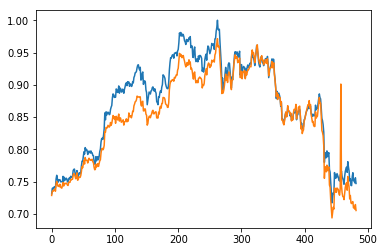

In [72]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: train_X, Y: train_y})
        train_predict = sess.run(Y_pred, feed_dict={X: train_X})
        m.update_state(train_y, train_predict)

        if i%100==0:
            print("[step: {}] loss: {}".format(i, step_loss,))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: test_X})
    rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(test_y)
    plt.plot(test_predict)
    plt.show()

In [73]:
test_y.shape ##(482,1)
test_y.dtype ##float64
test_predict.shape ##(482,1)
test_predict.dtype ##float32

#### 절대 다시 돌리지 말 것 ####
pred_GRU_7 = test_predict

In [75]:
diff = pred_GRU_7 - test_kospi #5일후 예측값 - t시점 지수종가
prediction = diff >= 0 #True면 '상승' = 1 False면 '하락' = 0

Y = kospi[['Y']]
true = Y.iloc[3962:-5,0].values
true = (true=='상승') #True면  1 = '상승' False면 0 = '하락'


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("accuracy: {}  \nconfusion matrix:\n {}\nf1: {}".format(accuracy_score(true, prediction), confusion_matrix(true, prediction), f1_score(true, prediction)))

accuracy: 0.42946058091286304  
confusion matrix:
 [[184  30]
 [245  23]]
f1: 0.14330218068535824
